In [1]:
# Load the packages
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from sklearn.datasets import load_iris, load_diabetes
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import mean_squared_error, r2_score

## Lesson summary
    
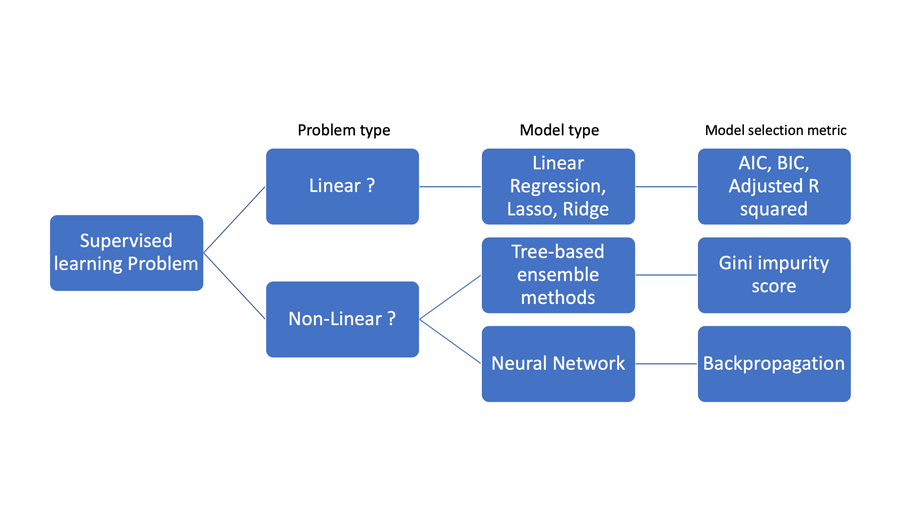

In this module we will focus on the following three model types:

1. Linear Models
2. Tree-based Ensemble Methods
3. Neural Network

Specifically, we will talk about their limitations and how practioners should select one over another.

## Identifying the problem type

- When given a supervised learning problem, one often starts by identifiying the nature of the data through *Exploratory Data Analysis (EDA)*. 

- If the dimensionality (i.e number of features) of the problem is small, then a simple `seaborn.pairplot` can nicely visualise the degree of linearity within the data. 

- If the relationship is linear, we can thus proceed with fitting a linear model (i.e linear regresion, Lasso, Ridge etc).

- If it turns out that the relationship is not so linear, or the dimensionality of the problem is high, then one can resort to non-linear models such as tree-based ensemble methods or neural networks.

## Visualising linear trends within data

Given a limited number of dimensions, we can visualise linear trends using `sns.pairplot`.

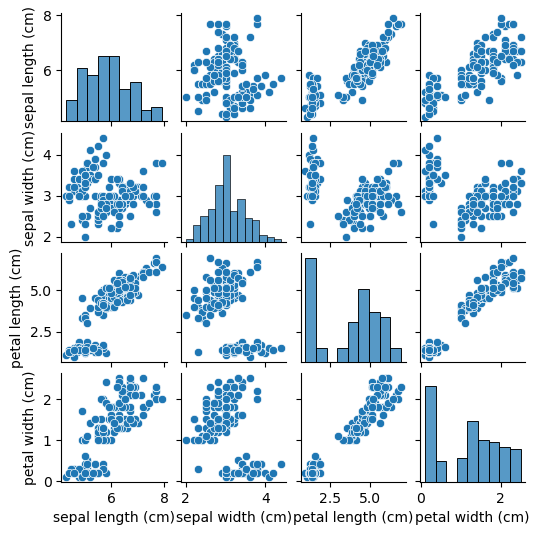

In [2]:
iris_data = load_iris()
iris_frame = pd.DataFrame(iris_data['data'])
iris_frame.columns = iris_data['feature_names']
sns.pairplot(iris_frame, height=1.35)
plt.show()

## Linear Mixture Model

In this case, for predicting petal width, from petal length the data seems linear enough. 

However, if we look at the plot petal width vs sepal width, there are two linear trends. This suggests to investigate a mixture of linear models instead. 

In statistics, a generalized linear mixed model (GLMM) is an extension to the generalized linear model (GLM) in which the linear predictor contains random effects in addition to the usual fixed effects. They also inherit from GLMs the idea of extending linear mixed models to non-normal data.

## Linear Mixture Model
Below we demonstrate an schematic pattern in the data, when GLMMs can be used:
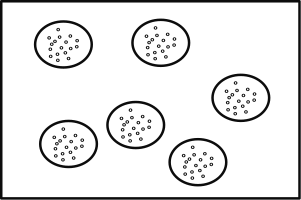

## Correlation 

Pairwise Correlation offers an alternative way to check linearity, but it has its own shortcomings as well.

In [3]:
iris_frame.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


Look at petal width vs sepal width, it has a correlation of `-0.36` suggesting low level of linearity, but in fact, the data comes from a mixture of linear models.

## Recap on machine learning models

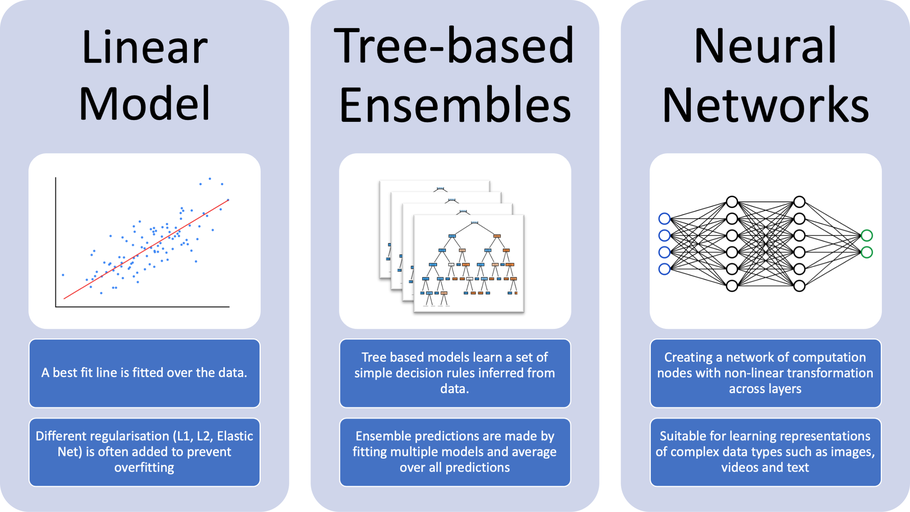

As previous modules have covered details of these methods, here we focus only on their similarities and differences. 

### Linear Model

Recall the general form of a linear model

$$
y = \alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 ... + \alpha_M x_M
$$

the $\vec{\alpha} = \{\alpha_m\}_{m=1}^M$ are often denoted as coefficients. Depending on the choice of our optimisation objective, we will obtain a different linear model. <br> The loss function can be written as the following:

$$
\mathcal{L} = ||\mathbf{y} - \vec{\alpha} \mathbf{X}||_2^2 + \Omega(\vec{\alpha})
$$

If $\Omega(\vec{\alpha}) = ||\vec{\alpha}||_1$ then we get the Lasso algorithm. If $\Omega(\vec{\alpha}) = ||\vec{\alpha}||_2$ then we get the Ridge regression algorithm.

In [4]:
# Linear Regression Example

target = np.array(iris_frame.loc[:,'petal width (cm)'])
predictor = np.array(iris_frame.loc[:, ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)']])

# Fit a linear model
lm = LinearRegression()
lm.fit(np.array(predictor), target)

# Access the result
predicted = lm.predict(predictor)
print("R2 Score: %.2f" %r2_score(predicted, target))
print("Root Mean Squared Error: %.2f" %np.sqrt(mean_squared_error(predicted, target)))

R2 Score: 0.93
Root Mean Squared Error: 0.19


Evaluation metrics for regression are harder to interpret than classificaiton. In the latter, metrics such as accuracy, precisions and recall are bounded within $[0, 1]$. Whereas common metrics such as `Root Mean Squared Error` are unbounded and the value depends on the problem we are solving. $R^2$ is a bounded measure but it is limited to linear models.

## Model Selection in case of Linear Models

- Recall that model selection is the problem of picking one desirable model from a set of candidate models. In Machine Learning, a common way of doing so is to pick one that performs best when predicting out of sample data, e.g. with **k-fold cross-validation** (or nested cross-validation, if enough data and compute power).

- Alternatively, we can leverage the probabilistic nature of linear models and quantify the desirability of a model by balancing **predictive performance** and **model complexity** using only the **training data**, by aiming for a *parsimonious* model - i.e. the model with the least number of parameters. The most commonly used examples are: 

    - Akaike Information Criterion (AIC)
       
    - Bayesian Information Criterion (BIC)

These both work in similar ways, penalising the models train log-likelihood by the number of parameters. I.e., if the model has more parameters, it needs to fit better (substantially) in order to justify them!

## AIC & BIC

AIC and BIC are measures that balance predictive power and complexity of a parametric model. In both cases, they are values that we want to **minimize** on the **training sample**:

$$\text{AIC} = 2k - 2 \ell$$
$$\text{BIC} = k \ln(N) - 2\ell$$

where $k$ is the number of coefficients in the linear model, $N$ is the number of data points (or the number of observations, or equivalently, the sample size) and $\ell$ is the log-likelihood of the model. 

As you can see, AIC only accounts for the number of parameters, where the BIC also accounts for the training sample size - the bigger the sample, the more the model is penalised per parameter. 

**Note**: *Both AIC and BIC try to estimate the log-likelihood on out-of-sample data using only the training data. The subtle differences in the AIC and BIC are to do with different assumptions on the true model, and each can be preferred in different contexts. As a high level summary, AIC should be used when you believe the true model (data generation process) to be more complex than the models you are testing, whereas BIC should be used when you believe that one of the models you will test is close to the true model. On complex problems with large data, minimizing the BIC is likely to result in underfitting.*

## Likelihood for regression

For classification problems with logistic regression, the log-likelihood is obvious - it is simply the same cross-entropy loss that is minimised in model training!

What about linear regression, where we minimise the MSE?

$$-\frac{N}{2} \ln(\text{MSE)}) + C$$

where $C$ is a constant that depends on the data.

We can remove $C$ from the equation as we only care about relative differences in AIC/BIC, and not the absolute values.

As such, for linear regression, our formulas are given by:

$$\text{AIC} = 2k + N \ln(\text{MSE})$$
$$\text{BIC} = k\ln(N) + N \ln(\text{MSE})$$

In [5]:
# AIC, BIC example:

def AIC(X, y, lm):
    """ Compute the AIC score of a linear model"""
    N = X.shape[0]
    y_pred = lm.predict(X)
    ll = (N/2)*np.log(mean_squared_error(y_pred, y))
    k = len(lm.coef_)
    
    return 2*k + 2*ll

def BIC(X, y, lm):
    """ Compute the BIC score of a linear model"""
    N = X.shape[0]
    y_pred = lm.predict(X)
    ll = (N/2)*np.log(mean_squared_error(y_pred, y))
    k = len(lm.coef_)
    
    return k*np.log(N) + 2*ll


print("AIC: %.2f" %AIC(predictor, target, lm))
print("BIC: %.2f" %BIC(predictor, target, lm))


AIC: -493.18
BIC: -484.15


In practice, to choose the "best" set of features to form the linear model, one could do:

1. Forward Selection:
    - Starting from the intercept and add a feature each time to the model recording the AIC/BIC at each step.
2. Backward Selection:
    - Starting from the full set of features and remove them 1 by 1 recording the AIC/BIC at each step.
3. Randomise Selection:
    - Randomly sample subsets of features to test for and record the AIC/BIC for each set of sample to determine the optimal configuration. 
    
The optimal feature subset is chosen based on the AIC (or BIC) value.

## Merits and limitations of linear models

Merits: 
- **Coefficients tell you the contribution each feature** has towards the prediction
- Easy to analyse for anomalies and explain
- Strong theoretical guarantees if linearity assumption is correct

Limitations:
- **Linearity is too restrictive** in practice
- Linearity is **not well-defined** in structured data such as images, videos, graphs, and texts.

## Tree based ensemble methods

- **Combine multiple weak learners** $f_1, f_2, ..., f_D$ and predict by taking averages of the models. 
- The key is to **instill extra randomness to improve generalisation** of the algorithm, thus preventing overfitting.

- Below is one possible way of combining predictions:

$$
f_{\text{ensemble}}(x) = \frac{1}{D} \sum_{d=1}^D f_d(x)
$$

- The most common choice of weak learner is a **decision tree**, but in principle you could combine different models as well, e.g. ensemble of linear models, ensemble of neural networks etc.

## Example of a Weak learner: Decision Trees

- A Decision Tree is a **simple to explain**, **easy to interpret** white box model.
- However, it **easily overfits** the data, and thus not necessarily generalise well.

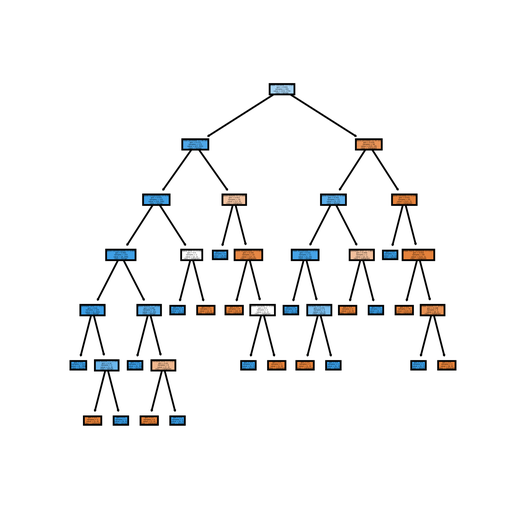

### Types of ensembling

- Bagging:
    - Stands for **B**ootstrap **Agg**regation.
    - Create copies of dataset by **resampling** and trains models $\{f_d\}_{d=1}^D$  on each of the copies. 
- Random Forest
    - On top of resampling datasets, during the training of the tree, instead of selecting the optimal feature to split (based on gini importance score), we **randomly select a feature** and search for the optimal splitting value inside.
- ExtraTrees 
    - Stands for Extremely random tree.
    - Similar to Random Forest, but the **splitting value is randomly chosen**.
- Gradient Boosting Machines (GBMs)
    - Instead of repeatedly fitting models on copies of datasets, we fit models forwardly on the error of the previous fit.
   

### Advantages and limitations of ensemble methods

Advantages:
- Flexible modelling tools that often achieve high accuracy for machine learning tasks on tabular data.

Limitations:
- Tuning might be cumbersome as model selection for ensembles requires selection for each component that makes up the ensemble.

When choosing from these models, Boosting trees is the usually the best performing model from the ones that can be used off-the-shelf. 

For the further performance boost, you might look into ensemble stacking, where the ensemble is built of varying types of weak estimators, including NNs. Alternatively, meta-ensembles can be used. 

In [6]:
# Illustration of different models

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor

diabetes = load_diabetes()
predictor = diabetes['data']
target = diabetes["target"]

X_train, X_test, y_train, y_test = train_test_split(predictor, target, test_size=0.3, random_state=1234)

bagging = BaggingRegressor()
bagging.fit(X_train, y_train)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)

print("Bagging MSE: %.2f"  %mean_squared_error(bagging.predict(X_test), y_test))
print("RF MSE: %.2f"  %mean_squared_error(rf.predict(X_test), y_test))
print("GBM MSE: %.2f"  %mean_squared_error(gbm.predict(X_test), y_test))

Bagging MSE: 3341.12
RF MSE: 3015.78
GBM MSE: 3060.56


## Neural networks

- Neural network is a very **general and flexible** model. It can be used for different data types such as graphs, images, text and videos etc.
- Below is the most basic architecture, known as the **fully-connected network** Image source: [Morse et al (2022)](https://www.researchgate.net/publication/360546296_Reliability-based_bottom-up_manufacturing_cost_optimisation_for_composite_aircraft_structures)
- This example has a single hidden layer and a single output node, so could be used for regression!

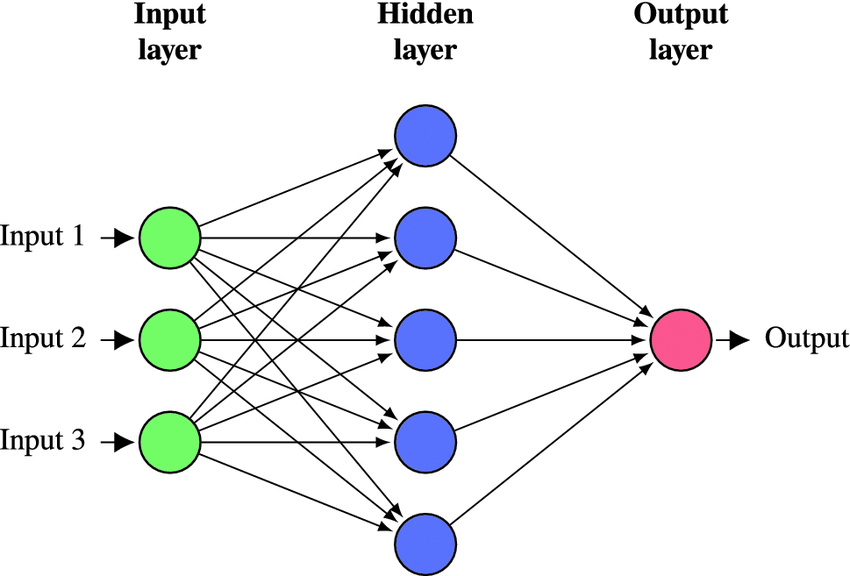

## Types:

There are several different types of neural networks that are used for different applications

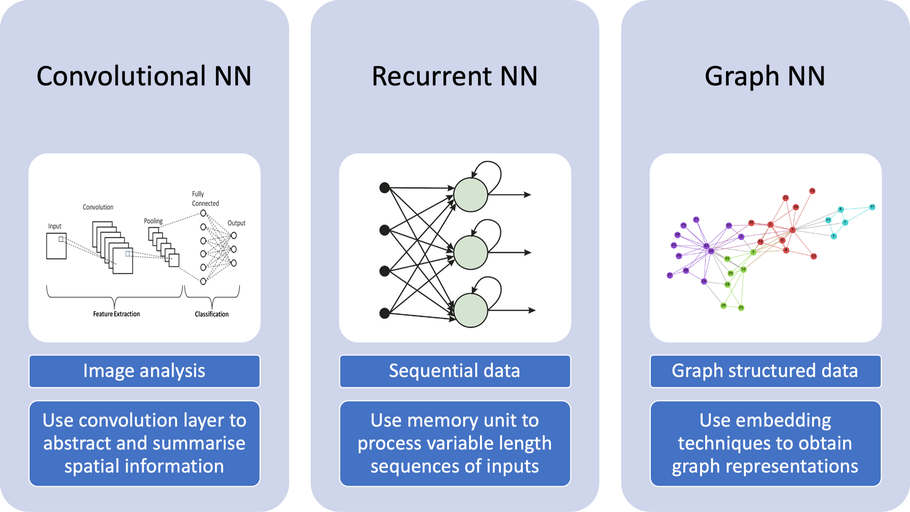

### How to train your neural network in practice?

There are three main components one often has to specifiy when training a neural network:

1. Model Architecture
    - Feedforward network? Convolution neural network? Graph neural network? 
2. Loss Function
    - L2 loss? Cross-entropy loss? Hinge loss? L2 loss with elastic net?
3. Optimisation Strategy
    - Gradient Descent? Stochastic Gradient Descent? ADAM? Momentum?
    
We will illustrate these components using the marvellous package PyTorch.

### Model Architecture

Using the function `torch.nn.Sequential()` allows us to simply create a neural network class.

In [7]:
model_example = torch.nn.Sequential(torch.nn.Linear(10, 20),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(20, 50),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(50, 1)
                                   )
model_example

Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=1, bias=True)
)

This gives us a 3-layer full connected neural network with [10, 20, 50] hidden nodes on each layer.

## Loss function

In PyTorch there are multiple loss functions that we can choose from.

In [8]:
# loss for binary classification
binary_cross_entropy_loss = torch.nn.BCELoss()

# loss for multi-class classification
cross_entropy_loss = torch.nn.CrossEntropyLoss()

# loss for regression
mean_squared_loss = torch.nn.MSELoss()

## Optimisation Strategy

After setting up the model architecture and our optimisation function, the final step is to handle the optimisation strategy. Almost all of them are derived based on the famous gradient descent algorithm:

$$
\alpha^* = \alpha + \epsilon \frac{\partial L}{\partial \alpha}
$$

Where $\alpha$ is the parameter of the model we need to tune, the gradient $\frac{\partial L}{\partial \alpha}$ tells us what the next improvement should be, and learning rate $\epsilon$ controls the magnitude of such improvement.

In [9]:
# For example, we can apply the adam optimiser over the model parameters with a learning rate `0.001`.
adam_opt = torch.optim.Adam(model_example.parameters(), lr=0.001)

## Combining all

Finally, a typical feedforward neural network code looks like the following:

In [10]:
class SimpleNeuralNetwork():
    
    def __init__(self, h1, epoch, verbose=False):
        """
        args:
            h1: number of nodes in hidden layer 1
            epoch: number of gradient updates
        """
        self.epoch = epoch
        self.h1 = h1
        self.verbose = verbose
    
    def fit(self, X, y):
        """
        args:
            X, y: predictor and target
        """
        n, p = X.shape
        inputs = torch.from_numpy(X).float()
        targets = torch.from_numpy(y).float()
        
        # Create the neural network model
        model = torch.nn.Sequential(torch.nn.Linear(p, self.h1),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(self.h1, 1))
        loss_fn = torch.nn.MSELoss()
        opt = torch.optim.SGD(model.parameters(), lr=1e-3)
        
        for rd in range(self.epoch):
            pred = model(inputs)
            loss = loss_fn(pred, targets)
                        
            if rd%300 == 0:
                print("loss: %.2f" %loss)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        self.model = model
    
    def predict(self, x_test):
        inputs = torch.from_numpy(x_test).float()
        return self.model(inputs).data.numpy()      

In [11]:
snn = SimpleNeuralNetwork(20, 1500)
snn.fit(X_train, y_train.reshape(-1, 1))

loss: 29093.37
loss: 3315.40


loss: 2932.25
loss: 2890.48
loss: 2884.64


In [12]:
print("Test error: %.2f" % mean_squared_error(snn.predict(X_test), y_test))

Test error: 2867.98


## Advantages and limitations of Neural Networks

Advantages:
- Flexibile modelling tool for various structured and unstructured data types such as images, videos, text, and graphs.

Disadvantages:
- Easily overfit and very difficult to tune in general.
- Often requires a lot of data to train for good performance compared with other traditional ML models.